# RN Text Classification

---
## Data Check

- NSMC 데이터
    - Naver sentiment movie corpus v1.0
    - 네이버 영화 댓글 감정분석 데이터셋
    - 이진 분류
- https://github.com/e9t/nsmc

In [112]:
import pandas as pd

df = pd.read_csv('data/ratings_train.txt', sep='\t')
df.head(2)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1


In [113]:
df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [114]:
df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [115]:
df = df.dropna(how='any', axis=0)
df.shape

(149995, 3)

---
## Tokenization

In [116]:
vocab = set()
for doc in df['document']:
    for token in doc.split():
        vocab.add(token)

In [117]:
len(vocab)

357862

In [118]:
vocab_cnt_dict = {}
for doc in df['document']:
    for token in doc.split():
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [119]:
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [120]:
vocab_cnt_list[:10]

[('아', 1204),
 ('더빙..', 2),
 ('진짜', 5929),
 ('짜증나네요', 10),
 ('목소리', 99),
 ('흠...포스터보고', 1),
 ('초딩영화줄....오버연기조차', 1),
 ('가볍지', 17),
 ('않구나', 2),
 ('너무재밓었다그래서보는것을추천한다', 1)]

In [121]:
top_vocabs = sorted(vocab_cnt_list, key= lambda tup: tup[1], reverse=True)

In [122]:
import matplotlib.pyplot as plt
import numpy as np

In [123]:
cnts = [cnt for _, cnt in top_vocabs]

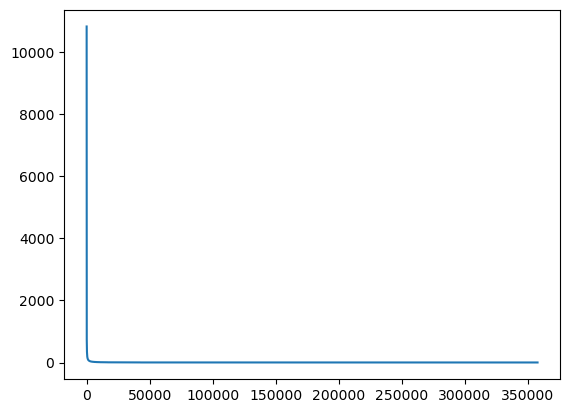

In [124]:
plt.plot(range(len(cnts)), cnts)

In [125]:
np.mean(cnts)

3.1792590439890236

In [126]:
cnts[:10]

[10825, 8239, 7791, 5929, 5059, 3598, 3285, 3260, 3249, 3237]

In [127]:
sum(np.array(cnts)>=3)

42635

In [128]:
n_vocab = sum(np.array(cnts)>=3)
top_vocabs = top_vocabs[:n_vocab]

In [129]:
vocabs = [token for token, _ in top_vocabs]
vocabs[:5]

['영화', '너무', '정말', '진짜', '이']

---
## UNK, PAD Token

In [130]:
vocabs.insert(0, '[UNK]')

In [131]:
vocabs.insert(0, '[PAD]')

In [132]:
idx_to_token = vocabs
token_to_idx = {token: i for i, token in enumerate(idx_to_token)}

In [133]:
class Tokenizer:
    
    def __init__(self, vocabs, use_padding=True, max_padding=64, pad_token='[PAD]', unk_token='[UNK]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        
        self.use_padding = use_padding
        self.max_padding = max_padding
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]
        
    def __call__(self, x:str):
        token_ids = []
        token_list = x.split()
        
        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)
        
        if self.use_padding:
            token_ids = token_ids[:self.max_padding]
            n_pads = self.max_padding - len(token_ids)
            token_ids = token_ids + [self.pad_token_idx] * n_pads
        
        return token_ids

In [134]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [135]:
sample = df['document'].iloc[0]
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [136]:
tokenizer(sample)

[51, 1, 5, 10485, 1064]

In [137]:
token_length_list = []
for sample in df['document']:
    token_length_list.append(len(tokenizer(sample)))

Text(0, 0.5, 'cnt')

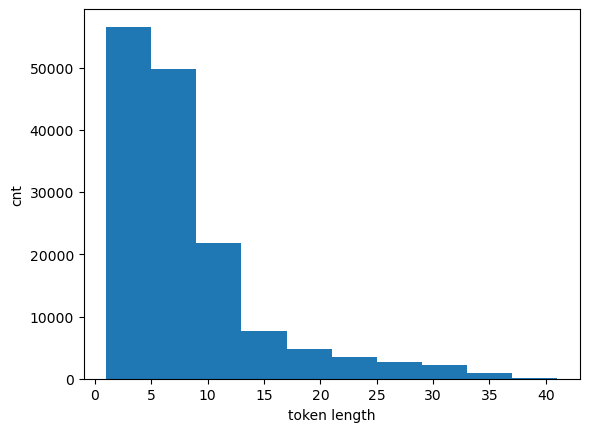

In [138]:
plt.hist(token_length_list)
plt.xlabel('token length')
plt.ylabel('cnt')

In [139]:
max(token_length_list)

41

In [140]:
tokenizer = Tokenizer(
    vocabs,
    use_padding=True,
    max_padding=50,
    pad_token='[PAD]',
    unk_token='[UNK]'
)

In [141]:
len(tokenizer(sample)), tokenizer(sample)[:10]

(50, [201, 2, 3635, 1, 121, 1946, 2, 0, 0, 0])

---
## DataLoader

In [142]:
import torch
from torch.utils.data import Dataset, DataLoader

In [143]:
train_valid_df = pd.read_csv('data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('data/ratings_test.txt', sep='\t')

In [144]:
len(train_valid_df), len(test_df)

(150000, 50000)

In [145]:
train_valid_df = train_valid_df.sample(frac=1.)

In [146]:
train_ratio = 0.8
n_train = int(len(train_valid_df) * train_ratio)

train_df = train_valid_df[:n_train]
valid_df = train_valid_df[n_train:]

In [147]:
len(train_df), len(valid_df), len(test_df)

(120000, 30000, 50000)

In [148]:
# 1/10 샘플링
train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
test_df = test_df.sample(frac=0.1)

In [149]:
class NSMCDataset(Dataset):
    
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        
        sample['doc'] = str(sample_raw['document'])
        sample['label'] = int(sample_raw['label'])
        
        assert sample['label'] in set([0, 1])
        
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc'])
        
        return sample

In [150]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}
    
    for item in batch:
        for key in keys:
            data[key].append(item[key])
    
    return data

In [151]:
train_dataset = NSMCDataset(
    data_df=train_df,
    tokenizer=tokenizer
)
valid_dataset = NSMCDataset(
    data_df=valid_df,
    tokenizer=tokenizer
)
test_dataset = NSMCDataset(
    data_df=test_df,
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              collate_fn=collate_fn,
                              shuffle=True)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=64,
                              collate_fn=collate_fn,
                              shuffle=False)
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             collate_fn=collate_fn,
                             shuffle=False)

In [152]:
sample = next(iter(test_dataloader))

In [153]:
sample.keys()

dict_keys(['doc', 'label', 'doc_ids'])

In [154]:
sample['doc'][2]

'브랜든은 엉망인채로 남아있을 것인가 나아졌을 것인가'

In [155]:
sample['doc_ids'][2][:10]

[1, 1, 21647, 7414, 1, 7414, 0, 0, 0, 0]

---
## RN Modeling

In [156]:
import torch
import torch.nn as nn

class RN(nn.Module):
    
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.output_dim = embed_dim
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        self.linear_l = nn.Linear(embed_dim, embed_dim)
        self.linear_r = nn.Linear(embed_dim, embed_dim)
        self.linear_rn = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, X):
        batch_size, seq_len = X.size()
        # batch size x seq_len x embed_dim
        X_embed = self.embeddings(X)
        # (batch_size * seq_len) x embed_dim
        X_flat = X_embed.view(batch_size * seq_len, self.embed_dim)
        # batch_size x 1 x seq_len x embed_dim
        X_l = self.linear_l(X_flat).view(batch_size, 1, seq_len, -1)
        # batch_size x seq_len x 1 x embed_dim
        X_r = self.linear_r(X_flat).view(batch_size, seq_len, 1, -1)
        # batch_size x seq_len x seq_len x embed_dim
        X_l = X_l.expand(-1, seq_len, -1, -1)
        X_r = X_r.expand(-1, -1, seq_len, -1)
        
        stnc_repr = self.linear_rn(
            torch.relu(X_l + X_r)
        ).view(
            batch_size, seq_len * seq_len, -1
        ).mean(dim=1)
        
        return stnc_repr

In [157]:
class Classifier(nn.Module):
    
    def __init__(self, sr_model, output_dim, vocab_size, embed_dim, **kwargs):
        super().__init__()
        
        self.sr_model = sr_model(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            **kwargs
        )
        self.input_dim = self.sr_model.output_dim
        self.output_dim = output_dim
        self.fc = nn.Linear(self.input_dim, self.output_dim)
        
    def forward(self, x):
        return self.fc(self.sr_model(x))

In [158]:
model = Classifier(
    sr_model=RN,
    output_dim=2,
    vocab_size=len(vocabs),
    embed_dim=16
)

In [159]:
model.sr_model.embeddings.weight[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

---
## Training

In [160]:
use_cuda = True and torch.cuda.is_available()

if use_cuda:
    model.cuda()

In [161]:
import torch.optim as optim
import numpy as np
from copy import deepcopy

In [162]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
calc_loss = nn.CrossEntropyLoss()

In [163]:
n_epoch = 5
global_i = 0

valid_loss_hist = []
train_loss_hist = []

min_valid_loss = 9e+9
best_model = None
best_epoch_i = None

for epoch_i in range(n_epoch):
    model.train()
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        x = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])
        
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        
        y_pred = model(x)
        loss = calc_loss(y_pred, y)
        
        if global_i % 200 == 0:
            print(f'global_i: {global_i}, epoch_i: {epoch_i}, loss: {loss.item()}')
        
        train_loss_hist.append((global_i, loss.item()))
        
        loss.backward()
        optimizer.step()
        
        global_i += 1
    
    # validation
    model.eval()
    valid_loss_list = []
    
    for batch in valid_dataloader:
        x = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])
        
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        
        y_pred = model(x)
        loss = calc_loss(y_pred, y)
        valid_loss_list.append(loss.item())
        
    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_hist.append((global_i, valid_loss_mean.item()))
    
    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        best_epoch_i = epoch_i
        best_model = deepcopy(model)
    
    if epoch_i % 1 == 0:
        print('*'*30)
        print(f'valid_loss_mean: {valid_loss_mean}')
        print('*'*30)
    
print(f'best_epoch_i: {best_epoch_i}, best_global_i: {global_i}')

global_i: 0, epoch_i: 0, loss: 0.6598941087722778
******************************
valid_loss_mean: 0.6905744608412397
******************************
global_i: 200, epoch_i: 1, loss: 0.6887080073356628
******************************
valid_loss_mean: 0.6857433382500994
******************************
global_i: 400, epoch_i: 2, loss: 0.6669826507568359
******************************
valid_loss_mean: 0.6630533198092846
******************************
global_i: 600, epoch_i: 3, loss: 0.6247557997703552
******************************
valid_loss_mean: 0.6364156413585582
******************************
global_i: 800, epoch_i: 4, loss: 0.5820186138153076
******************************
valid_loss_mean: 0.6278798681624392
******************************
best_epoch_i: 4, best_global_i: 940


---
## Learning Curve

In [164]:
def calc_moving_average(arr, win_size=100):
    new_arr = []
    win = []
    
    for i, val in enumerate(arr):
        win.append(val)
        if len(win) > win_size:
            win.pop(0)
        
        new_arr.append(np.mean(win))
        
    return np.array(new_arr)

Text(0, 0.5, 'loss')

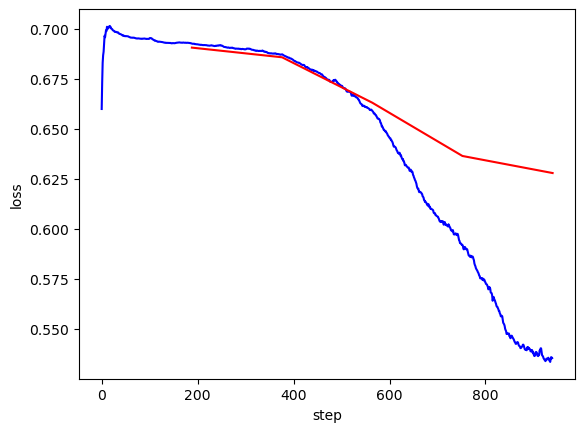

In [165]:
valid_loss_hist = np.array(valid_loss_hist)
train_loss_hist = np.array(train_loss_hist)

plt.Figure(figsize=(12, 8))
plt.plot(train_loss_hist[:, 0], calc_moving_average(train_loss_hist[:, 1]), color='blue')
plt.plot(valid_loss_hist[:, 0], valid_loss_hist[:, 1], color='red')
plt.xlabel('step')
plt.ylabel('loss')

---
## Evaluation

In [166]:
from tqdm.auto import tqdm

In [167]:
model = best_model

model.eval()

total = 0
correct = 0

for batch in tqdm(
    test_dataloader,
    total=len(test_dataloader.dataset) // test_dataloader.batch_size
):
    x = torch.tensor(batch['doc_ids'])
    y = torch.tensor(batch['label'])
    
    if use_cuda:
        x = x.cuda()
        y = y.cuda()
    y_pred = model(x)
    
    curr_correct = y_pred.argmax(dim=1) == y
    
    total += len(curr_correct)
    correct += sum(curr_correct)
    
print(f'test accuracy: {correct/total}')

  0%|          | 0/78 [00:00<?, ?it/s]

test accuracy: 0.6312000155448914
